In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

In [8]:
# Load your dataset
data = pd.read_csv('preprocessed_data.csv')
data

,Id,Review,Label,cleaned_reviews
0,0,good and interesting,5,ood interesting
1,1,"This class is very helpful to me. Currently, I...",5,"class helpful . currently , 'm still learning ..."
2,2,like!Prof and TAs are helpful and the discussi...,5,ike ! prof ta helpful discussion among student...
3,3,Easy to follow and includes a lot basic and im...,5,asy follow includes lot basic important techni...
4,4,Really nice teacher!I could got the point eazl...,4,eally nice teacher ! could got point eazliy v
...,...,...,...,...
107013,107013,Trendy topic with talks from expertises in the...,4,rendy topic talk expertise field . covered are...
107014,107014,"Wonderful! Simple and clear language, good ins...",5,"onderful ! simple clear language , good instru..."
107015,107015,an interesting and fun course. thanks. dr quincy,5,n interesting fun course . thanks . dr quincy
107016,107016,"very broad perspective, up to date information...",4,"ery broad perspective , date information , use..."


In [5]:
# Calculate Z-scores for Labels (assuming Labels is the sentiment score)
data['z_score'] = (data['Label'] - data['Label'].mean()) / data['Label'].std()

In [37]:
# Identify outliers based on Z-score
outliers_z = data[np.abs(data['z_score']) > 3]
data = data[np.abs(data['z_score']) <= 3]
data

KeyError: 'z_score'

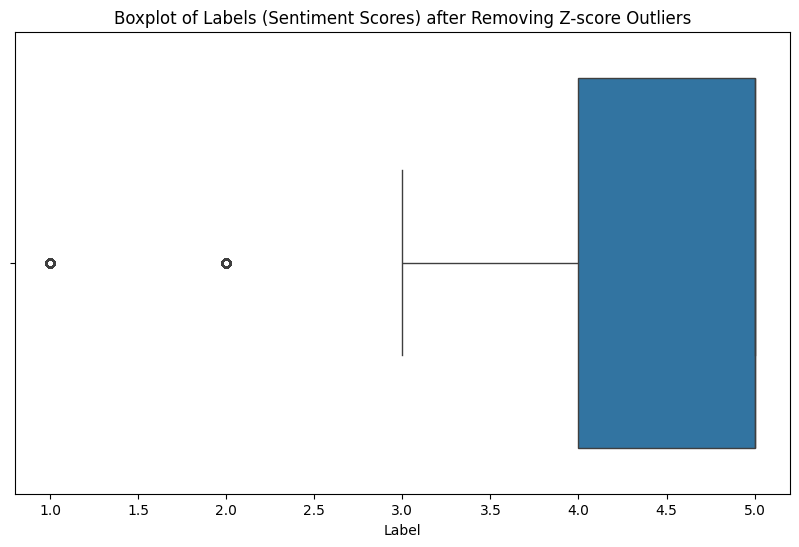

In [10]:
# Visualize Labels without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Label'])
plt.title('Boxplot of Labels (Sentiment Scores) after Removing Z-score Outliers')
plt.show()

In [15]:
# Convert cleaned_reviews data to TF-IDF features
vectorizer = TfidfVectorizer()
X = data['cleaned_reviews']
Y = data['Label']
X.fillna('', inplace=True)
tfidf_matrix = vectorizer.fit_transform(data['cleaned_reviews'])

In [18]:
# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=10)
svd_features = svd.fit_transform(tfidf_matrix)

In [19]:
# Use Local Outlier Factor (LOF) to detect outliers in the reduced feature space
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(svd_features)

In [20]:
# Add the outlier labels to the dataset
data['outlier_lof'] = outlier_labels

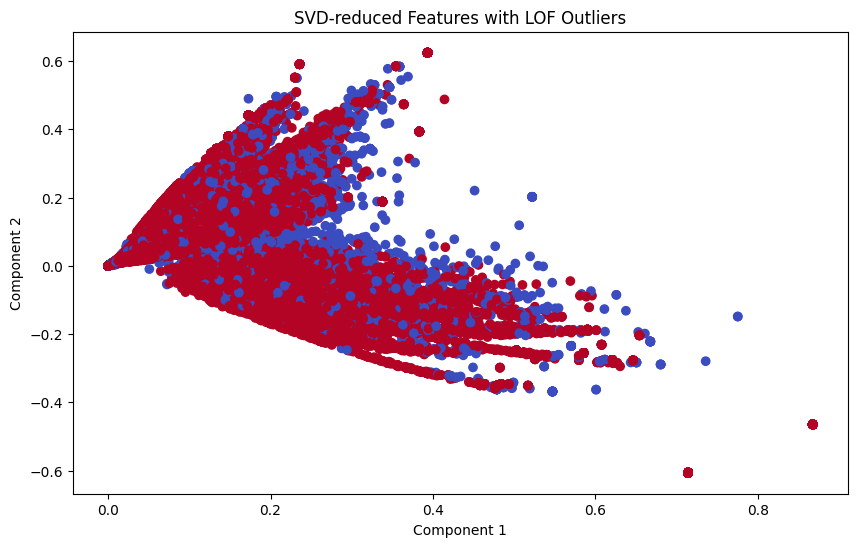

In [21]:
# Visualize the SVD-reduced features with outliers
plt.figure(figsize=(10, 6))
plt.scatter(svd_features[:, 0], svd_features[:, 1], c=outlier_labels, cmap='coolwarm', marker='o')
plt.title('SVD-reduced Features with LOF Outliers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [22]:
outliers_lof = data[data['outlier_lof'] == -1]
# Remove LOF outliers from the dataset
data = data[data['outlier_lof'] != -1]

In [24]:
# Apply SMOTE to balance the dataset
smote = SMOTE()
tfidf_matrix_resampled, labels_resampled = smote.fit_resample(tfidf_matrix[data.index], data['Label'])

In [25]:
# Optionally, apply TruncatedSVD again to the resampled data for visualization
svd_resampled = TruncatedSVD(n_components=2)
svd_features_resampled = svd_resampled.fit_transform(tfidf_matrix_resampled)

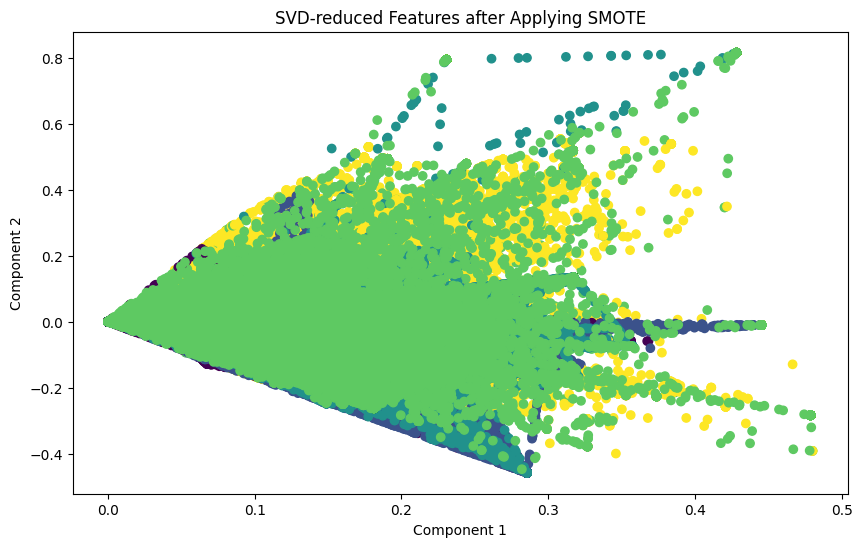

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(svd_features_resampled[:, 0], svd_features_resampled[:, 1], c=labels_resampled, cmap='viridis', marker='o')
plt.title('SVD-reduced Features after Applying SMOTE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [32]:
# Final cleaned and balanced dataset
# Note: tfidf_matrix_resampled is still in sparse format
cleaned_data = csr_matrix(tfidf_matrix_resampled)  # Keep the data in sparse format
labels_resampled = np.array(labels_resampled).reshape(-1, 1)  # Convert labels to a 2D array

print("Cleaned and balanced dataset (sparse format):")
print(cleaned_data.shape)
print(labels_resampled.shape)

Cleaned and balanced dataset (sparse format):
(353800, 32683)
(353800, 1)


In [36]:
cleaned_data

<353800x32683 sparse matrix of type '<class 'numpy.float64'>'
	with 8004922 stored elements in Compressed Sparse Row format>